## Aula: Prática em Overfit e Underfit


### Antes da aula:
1. Continue utilizando link para feedback. Podem enviar quantas vezes quiserem ao longo de todo curso: Link: https://docs.google.com/forms/d/1Gk9OPPJR05V19MoRQXOdjUuPmwx0h28uLx-ESykV3mc/edit. No último feedback recebido foi pedido que falassemos mais sobre o mercado de trabalho, projetos reais IBM  e Hop.

2. Participe da Aula no <img src="https://www.sli.do/build/img/common/slido-logo-85be3781bc.svg" width="50"/>: https://app.sli.do/event/2bfhigxu. Ou entre em https://sli.do e use o código #IACD-UNIBH.

### Ilustração  sobre Overfitting 
<div>
<img src="https://thedatafrog.s3.amazonaws.com/media/images/ecodigesteur_web.max-1000x500.png" width="800"/>
<img src="https://i.redd.it/ze7i4nhq0se41.jpg" width="300"/>
</div>

## Exemplo 1: Toy Problem

Temos uma função a ser descoberta (true_fun). Vamos tentar descobrir seus parametros utilizando polinômios de diferentes graus.

In [0]:
# Inspired by: https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html
# Altered by: Matheus Araujo

import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
%matplotlib inline 

### Definindo qual será a 'true_fun'

In [0]:
# Funcao Linear
#def true_fun(X):
#    return -0.3242*X + 0.342

# Funcao Quadratica
# def true_fun(X):
#     return - X**2/5 + 0.5 + X/2

# Funcao de Quarto grau
 def true_fun(X):
     return 5 * X**4 - 2*X**2

#Funcao Cosseno
# def true_fun(X):
#     return np.cos(3 * np.pi * X)

### Realizando  Experimento

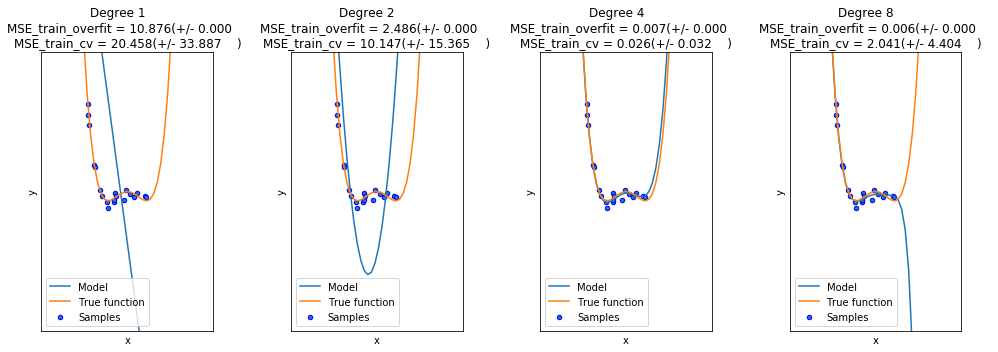

In [0]:
# Fixando seed
np.random.seed(42)
# Numero de dados para treino
n_samples = 30
# Quais graus serão tentados para modelar os dados
degrees = [1, 2, 4, 8]

# Definindo dados de treino
X = np.sort(np.random.rand(n_samples)) *2 -1.5
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))

# Para cada grau de polinomio iremos tentar modelar os dados
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()

    #Pipeline é o nosso modelo de Regressão Polinomial
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Avaliamos o modelo utilizando cross-validation
    scores_cv = cross_val_score(pipeline, X[:, np.newaxis], y, scoring="neg_mean_squared_error", cv=10)
    
    # Avaliamos o modelo sem cross-validation
    scores_overfit = np.array([mean_squared_error(pipeline.predict(X[:, np.newaxis]), y)])

    X_test = np.linspace(-2, 2, 50)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((-2, 2))
    plt.ylim((-3, 3))
    plt.legend(loc="best")
    plt.title("Degree {} \
    \nMSE_train_overfit = {:.3f}(+/- {:.3f}\
    \nMSE_train_cv = {:.3f}(+/- {:.3f}\
    )".format(degrees[i],scores_overfit.mean(), scores_overfit.std(), -scores_cv.mean(), scores_cv.std()))
plt.tight_layout()
plt.show()

## Exemplo 2: Modelando o preço das casas em Boston

In [0]:
from sklearn.datasets import load_boston
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from IPython.display import SVG, Image
from IPython.display import display
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn import tree

data = load_boston(return_X_y=False)


In [0]:
X = pd.DataFrame(data["data"], columns=data['feature_names'])
y = data["target"]


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

### Valores das Casas

In [0]:
print("Mean value: {} Std value: {}".format(y_train.mean(), y_train.std()))

Mean value: 22.748616600790513 Std value: 9.360325831253647


### Primeira Tentativa: sem cross validation, parametros default

In [0]:
clf = DecisionTreeRegressor(max_features=None)
clf.fit(X_train, y_train)
train_score = mean_squared_error(clf.predict(X_train), y_train)
test_score = mean_squared_error(clf.predict(X_test), y_test)
print("Train MSE: {} Test MSE: {}".format(train_score, test_score)) 
graph = Source(tree.export_graphviz(clf, out_file=None, feature_names=X.columns, filled = True))
display(Image(graph.pipe(format='png')))

Output hidden; open in https://colab.research.google.com to view.

### Segunda Tentativa: Com cross-validation

Best params: {'min_samples_split': 17, 'min_samples_leaf': 13, 'min_impurity_decrease': 0.07, 'max_depth': 4}
Train MSE: -19.353628021241285 Test MSE: 21.967094138018496


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


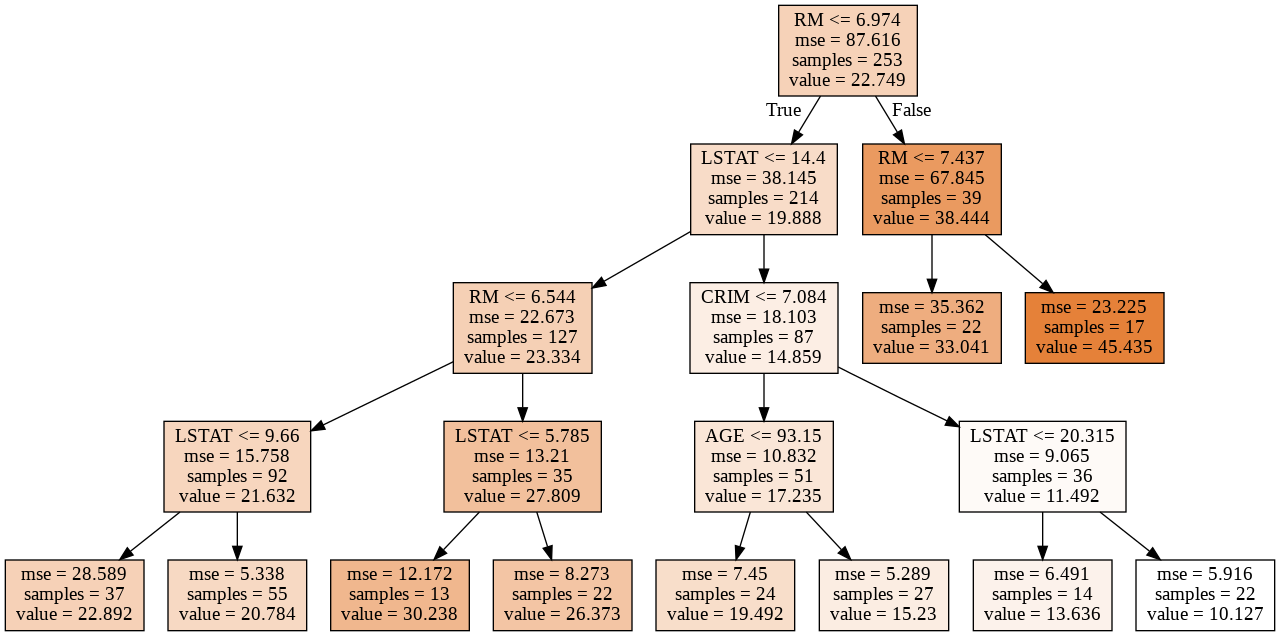

In [0]:
param_grid={
        'min_samples_split': range(2, 100, 5),
        'max_depth' : range(1, 20),
        'min_samples_leaf' : range(5,20),
        'min_impurity_decrease' : np.arange(0,1, 0.01),
        }
clf = DecisionTreeRegressor()
clf_cv = RandomizedSearchCV(clf, param_grid,iid=True,n_iter=1000,scoring='neg_mean_squared_error', random_state=42, refit=True)
clf_cv.fit(X_train, y_train)
train_score = clf_cv.best_score_
test_score = mean_squared_error(clf_cv.predict(X_test), y_test)
print("Best params: {}".format(clf_cv.best_params_))
print("Train MSE: {} Test MSE: {}".format(train_score, test_score))
graph = Source(tree.export_graphviz(clf_cv.best_estimator_, out_file=None, feature_names=X.columns, filled = True))
display(Image(graph.pipe(format='png')))